In [3]:
import numpy as np
import cv2
from cv2 import dnn


In [8]:
proto_file = '/content/drive/MyDrive/Models/colorization_deploy_v2.prototxt'
model_file = '/content/drive/MyDrive/Models/colorization_release_v2.caffemodel'
hull_pts = '/content/drive/MyDrive/Models/pts_in_hull.npy'

In [5]:
img_path = '/content/drive/MyDrive/images.jpeg'

In [10]:
net = dnn.readNetFromCaffe(proto_file,model_file)
kernel = np.load(hull_pts)

In [11]:
img = cv2.imread(img_path)
scaled = img.astype("float32") / 255.0
lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

In [12]:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = kernel.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

In [13]:
resized = cv2.resize(lab_img, (224, 224))
# split the L channel
L = cv2.split(resized)[0]
# mean subtraction
L -= 50

In [14]:
net.setInput(cv2.dnn.blobFromImage(L))
ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))
# resize the predicted 'ab' volume to the same dimensions as our
# input image
ab_channel = cv2.resize(ab_channel, (img.shape[1], img.shape[0]))


In [17]:
L = cv2.split(lab_img)[0]
# Join the L channel with predicted ab channel
colorized = np.concatenate((L[:, :, np.newaxis], ab_channel), axis=2)

# Then convert the image from Lab to BGR
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")

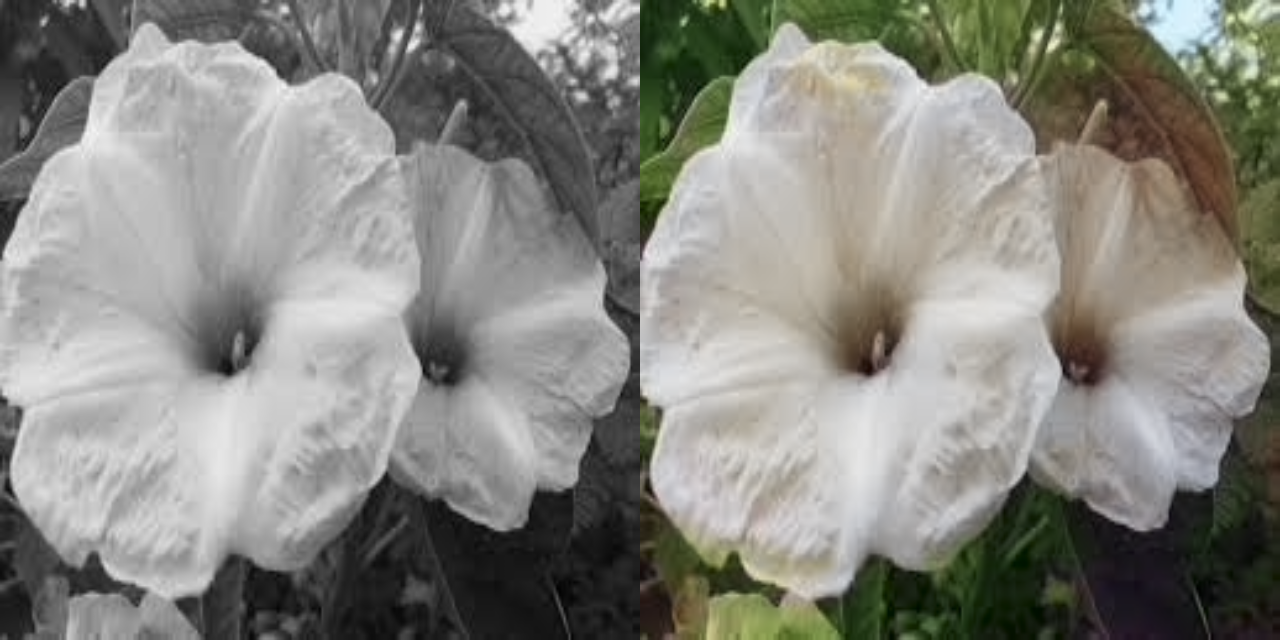

-1

In [19]:
from google.colab.patches import cv2_imshow

# Let's resize the images and show them together
img = cv2.resize(img,(640,640))
colorized = cv2.resize(colorized,(640,640))

result = cv2.hconcat([img,colorized])

cv2_imshow(result)

cv2.waitKey(0)